# Shapley for data valuation

This notebook introduces Shapley methods for the computation of data value using pyDVL.

In order to show the practical advantages of shapley pydvl implementation, we will predict the popularity of songs in the "Top Hits Spotify from 2000-2019" dataset. While doing so, we will highlight how data valuation can help boost the performance of your models.

Here, all the library main entry-points will be briefly described. Let's start with some imports

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

from pydvl.utils import (
    load_spotify_dataset,
    Dataset,
    GroupedDataset,
    Utility,
    plot_shapley,
)
from pydvl.shapley import compute_shapley_values

In [3]:
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10

## Constants

In [4]:
random_state = 24
is_CI = os.environ.get("CI")
enable_cache = not is_CI

In [5]:
random.seed(random_state)

## Dataset

To load the dataset, we will use the load_spotify_dataset method. Internally, the method loads data on songs published after 2014, use 30% of data for test, and another 30% of the remaining data for validation. Then, the method will return train, validation and test data as lists like [X_input, Y_label]

In [6]:
train_data, val_data, test_data = load_spotify_dataset(
    val_size=0.3, test_size=0.3, target_column="popularity", random_state=random_state
)
# In CI we only use a subset of the training set
if is_CI:
    train_data[0] = train_data[0].iloc[:5]
    train_data[1] = train_data[1].iloc[:5]

train_data[0].head()

,artist,song,duration_ms,explicit,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
1561,Fetty Wap,679 (feat. Remy Boyz),196693,True,2015,0.618,0.717,7,-5.738,1,0.3180,0.00256,0.000000,0.6250,0.603,190.050,8
1410,Meghan Trainor,All About That Bass,187920,True,2015,0.807,0.887,9,-3.726,1,0.0503,0.05730,0.000003,0.1240,0.961,134.052,14
1772,Katy Perry,Chained To The Rhythm,237733,False,2017,0.562,0.800,0,-5.404,1,0.1120,0.08140,0.000000,0.1990,0.471,95.029,14
1670,Sigala,Sweet Lovin' - Radio Edit,202149,False,2015,0.683,0.910,10,-1.231,1,0.0515,0.05530,0.000005,0.3360,0.674,124.977,15
1780,Liam Payne,Strip That Down,204502,False,2017,0.869,0.485,6,-5.595,1,0.0545,0.24600,0.000000,0.0765,0.527,106.028,14


The dataset has many high level features, some quite intuitive ('duration_ms' or 'tempo'), and other a bit more cryptic ('valence'?). For information on each feature,visit [this webpage](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019?resource=download).
In our analysis, we will use all the columns, excluding 'artist' and 'song', to predict the 'popularity' of each song. We will nonetheless keep the information on song and artist in a separate object for future reference.

In [7]:
song_name = train_data[0]["song"]
artist = train_data[0]["artist"]
train_data[0] = train_data[0].drop(["song", "artist"], axis=1)
test_data[0] = test_data[0].drop(["song", "artist"], axis=1)
val_data[0] = val_data[0].drop(["song", "artist"], axis=1)

Input and label data need to be stored in a Dataset object, a pyDVL specific class.

In [8]:
dataset = Dataset(*train_data, *val_data)

The calculation of Shapley coefficients is very computationally expensive because it needs to go through several subsets of the original dataset before converging. For this reason, the PyDVL library implements techniques to speed up the calculation, such as caching intermediate results and grouping data to calculate group Shapley values instead of single-datapoints. 

In our case, we will group each single song by artist and calculate the Shapley value for each of them. Given the artist pandas Series, to create a grouped dataset you can just do the following

In [9]:
grouped_dataset = GroupedDataset.from_dataset(dataset=dataset, data_groups=artist)

And now we can finally calculate the contribution of each group to the model performance!

As model, we will use a GradientBoostingRegressor, but any model from sklearn, xgboost and lightgbm works. More precisely, any model that has a fit and predict method should run without issues.

To give a score to our model, we will pass a string which refers to the standard sklearn scoring methods. You can find all other available options in the [sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html). There you can also find how to define your own scoring function if needed.

If you plan to use the cache (enable_cache = True), make sure to restart (or simply start if it is not already running) your memcache. See our [documentation](https://appliedai-initiative.github.io/valuation/install.html) for details.

In [10]:
utility = Utility(
    model=GradientBoostingRegressor(n_estimators=3),
    data=grouped_dataset,
    scoring="neg_mean_absolute_error",
    enable_cache=enable_cache,
)
dvl_df = compute_shapley_values(utility, max_iterations=100, n_jobs=8)

2022-10-06 15:55:28,116	INFO worker.py:1518 -- Started a local Ray instance.


The first object that was have defined (utility) holds all the information on the dataset, the model and the scoring.
The second method, shapley_values, calculates the actual Shapley values and manages parallelization. Let's take a look at the returned dataframe.

In [11]:
dvl_df.head()

,data_value,data_value_std
CNCO,-1.915079,0.824878
AlunaGeorge,-1.860582,0.759359
Rich Homie Quan,-1.782366,0.746033
Ariana Grande,-1.476541,0.573938
Kendrick Lamar,-1.408348,0.450465


The first thing to notice is that the dvl_df dataframe is sorted in ascending order of shapley values. The data_key columns holds the labels for each data group: in this case, since the groups correspond to artists, it coincides with artist names. The second column corresponds to the shapley data valuation score, and the third to its (approximate) standard deviation.

Let's plot the results. In the next cell we will take the 30 datapoints with lowest score and plot them with (approximate) errorbars. Keep in mind that montecarlo Shapley is typically very noisy, so it may take several steps before arriving at a non-noisy, non-biased estimate.

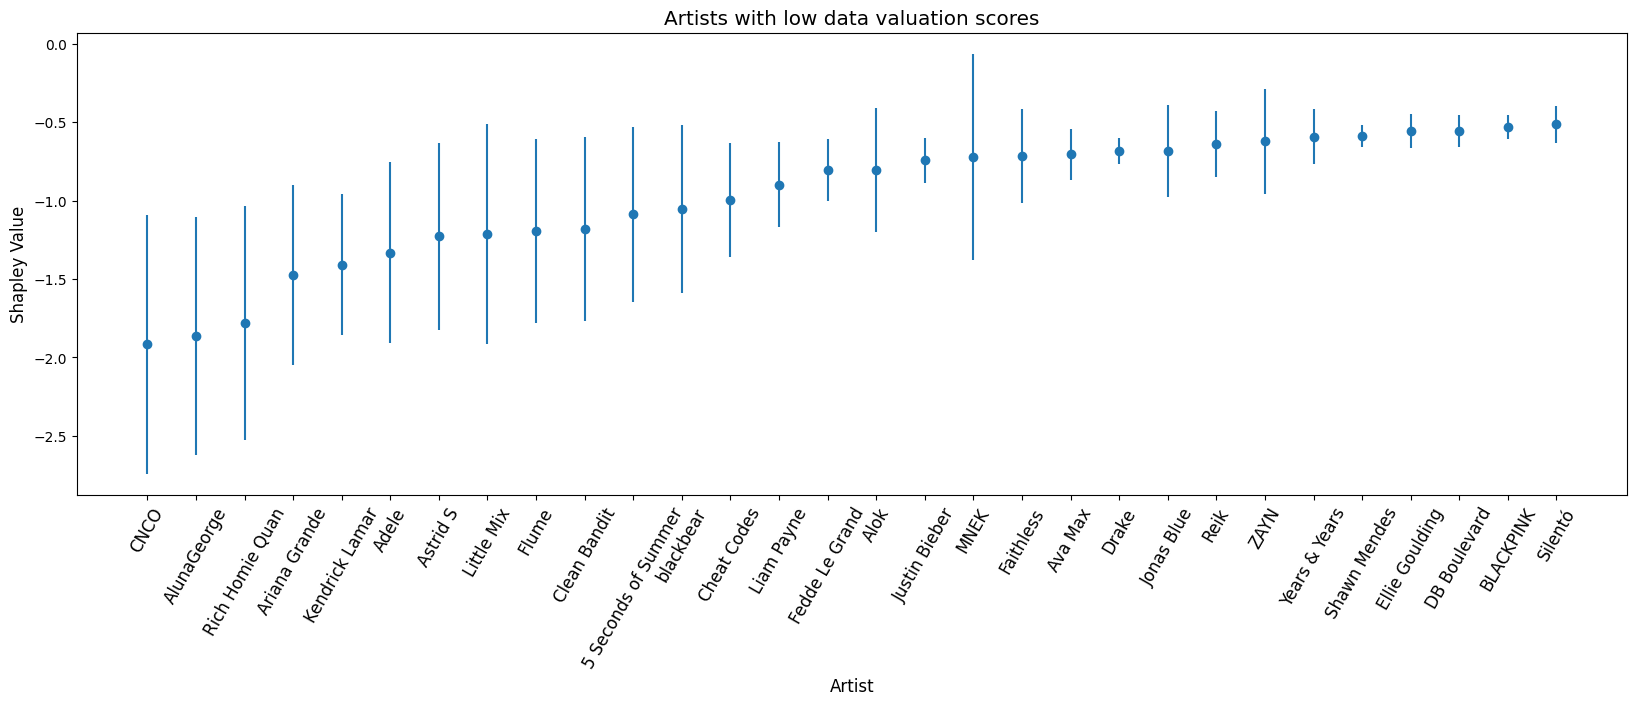

In [12]:
low_dvl = dvl_df.iloc[:30]
fig, ax = plt.subplots()
plot_shapley(
    low_dvl,
    ax=ax,
    title="Artists with low data valuation scores",
    xlabel="Artist",
    ylabel="Shapley Value",
)
plt.show()

As you can see, there are a lot of points which give negative shapley score, meaning that they tend to decrease the total score of the model when present in the training set! What happens if we remove them? In the next cell we will create a new training set which excludes the 30 points with lowest scores.

In [13]:
low_dvl_artists = dvl_df.iloc[:30].index.to_list()
artist_filter = ~artist.isin(low_dvl_artists)
X_train_good_dvl = train_data[0][artist_filter]
y_train_good_dvl = train_data[1][artist_filter]

Now we will use this cleaned dataset to train a full GradientBoostingRegressor and compare its mean absolute error to the model which uses the full dataset. Notice that the score now is calculated using the test set, while in the calculation of the shapley values we were using the validation set.

In [14]:
full_model = GradientBoostingRegressor(n_estimators=3).fit(
    X_train_good_dvl, y_train_good_dvl
)
mean_absolute_error(full_model.predict(test_data[0]), test_data[1])

16.94998610601937

In [15]:
full_model = GradientBoostingRegressor(n_estimators=3).fit(train_data[0], train_data[1])
mean_absolute_error(full_model.predict(test_data[0]), test_data[1])

19.49470900052308

The score has improved by more than 15%! This is quite an important result, as it shows a self-consistent process to improve the performance of a model by excluding datapoints from its training set.

## Evaluation on anomalous data

Another interesting test is to corrupt some of the data and monitor how their valuation score changes. To do this, we will take one of the authors with the highest score and set all its popularity to 0.

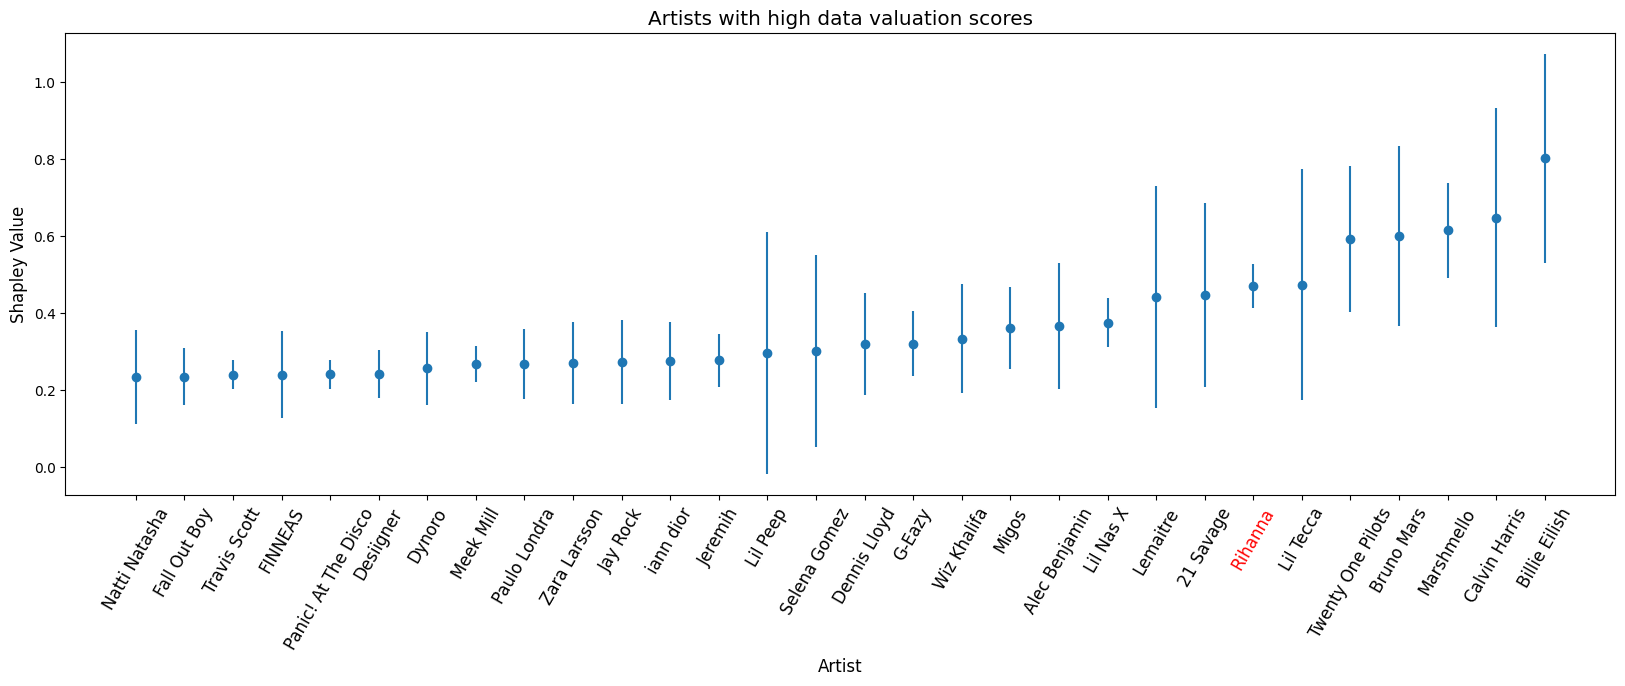

In [16]:
high_dvl = dvl_df.iloc[-30:]
fig, ax = plt.subplots()
plot_shapley(
    high_dvl,
    ax=ax,
    title="Artists with high data valuation scores",
    xlabel="Artist",
    ylabel="Shapley Value",
)
ax.get_xticklabels()[high_dvl.index.get_loc("Rihanna")].set_color("red")
plt.show()

From the plot above, we can see that Rihanna has one of the highest scores. Let's now take all the train labels related to her, set the score to 0 and re-calculate the data valuation scores. Notice that I must use a new name for the dataset, because I need to create another cache. Reusing the old one would be a mistake since modifying even just one label changes all the shapley values.

In [17]:
y_train_anomalous = train_data[1].copy(deep=True)
y_train_anomalous[artist == "Rihanna"] = 0
anomalous_dataset = Dataset(
    x_train=train_data[0],
    y_train=y_train_anomalous,
    x_test=val_data[0],
    y_test=val_data[1],
)
grouped_anomalous_dataset = GroupedDataset.from_dataset(anomalous_dataset, artist)
utility = Utility(
    model=GradientBoostingRegressor(n_estimators=3),
    data=grouped_anomalous_dataset,
    scoring="neg_mean_absolute_error",
    enable_cache=True,
)
dvl_df = compute_shapley_values(utility, max_iterations=100, n_jobs=8)

Let's now take the low scoring artists and plot the results

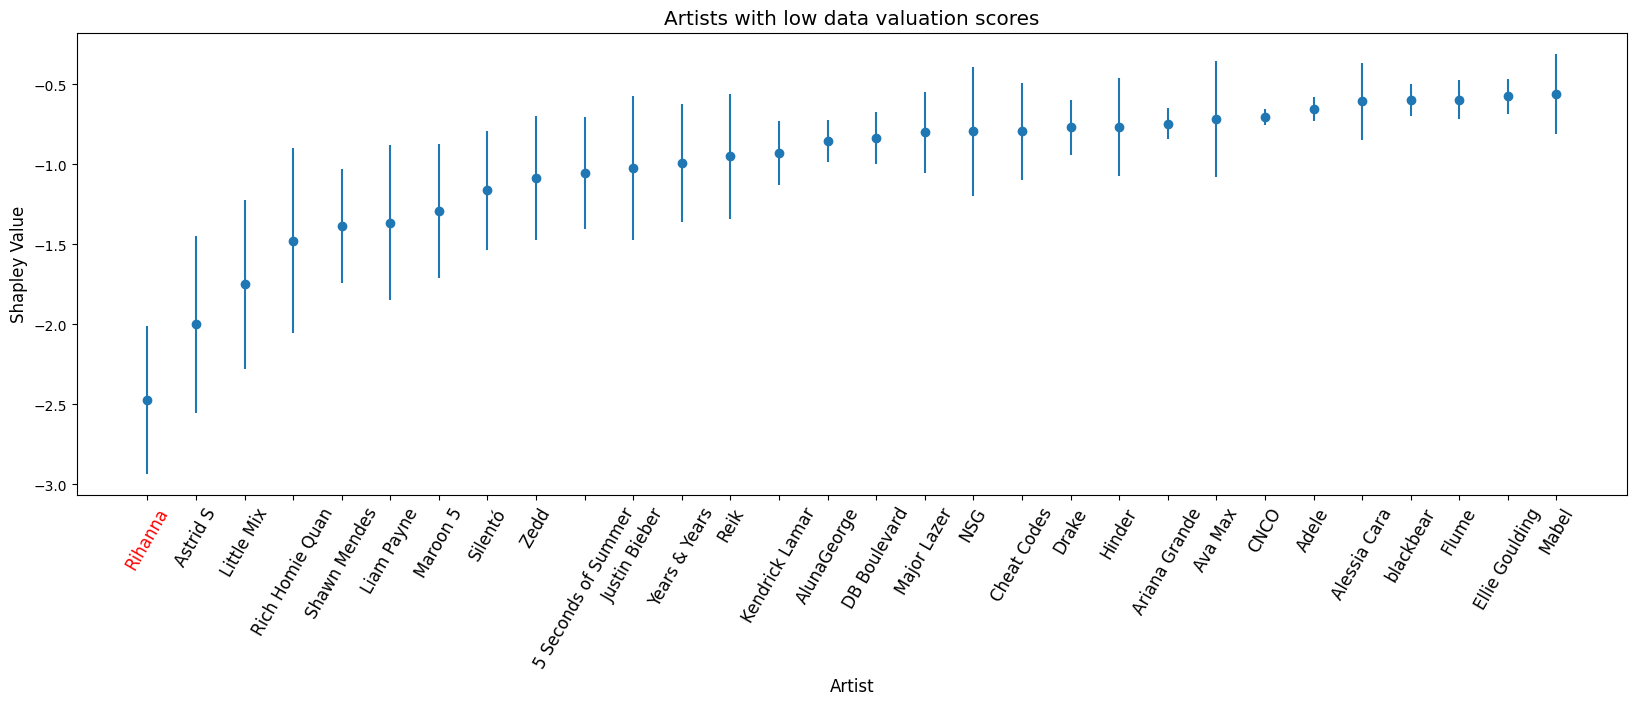

In [18]:
low_dvl = dvl_df.iloc[:30]
fig, ax = plt.subplots()
ax = plot_shapley(
    low_dvl,
    ax=ax,
    title="Artists with low data valuation scores",
    xlabel="Artist",
    ylabel="Shapley Value",
)
ax.get_xticklabels()[low_dvl.index.get_loc("Rihanna")].set_color("red")
plt.show()

And Rihanna (our anomalous data group) has moved from top contributor to having negative impact on the performance of the model, as expected!